# Deep Dream

This guide covers deep dreaming with visual. First, we'll load in a model and an image, then perform a simple deep dream. Next we'll show how visual can be used for deep dreaming in Fourier space and with de-correlated colour.

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Visual

First we install visual if needed. 

In [1]:
try:
    import visual
except:
    !pip install -q git+https://github.com/pytorchbearer/visual
    import visual
    
print(visual.__version__)

0.2.0.dev


## Load a Model

As usual, load a model. This time, we'll use the ResNet18 from torchvision. We also create our transform here as it will be fixed for the duration of the notebook.

In [2]:
from visual.models import IntermediateLayerGetter
from visual import RedirectReLUs
from torchvision.models import vgg19
from torchvision.transforms import Normalize
from visual import transforms


model = IntermediateLayerGetter(RedirectReLUs(vgg19(pretrained=True)))
print(model.layer_names)

normalize = Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.SpatialJitter(2),
    transforms.RandomScale([1.1 ** (n / 10.) for n in range(-10, 11)]),
    transforms.RandomRotate(list(range(-5, 6))),
    normalize
])

['model', 'model_features', 'model_features_0', 'model_features_1', 'model_features_2', 'model_features_3', 'model_features_4', 'model_features_5', 'model_features_6', 'model_features_7', 'model_features_8', 'model_features_9', 'model_features_10', 'model_features_11', 'model_features_12', 'model_features_13', 'model_features_14', 'model_features_15', 'model_features_16', 'model_features_17', 'model_features_18', 'model_features_19', 'model_features_20', 'model_features_21', 'model_features_22', 'model_features_23', 'model_features_24', 'model_features_25', 'model_features_26', 'model_features_27', 'model_features_28', 'model_features_29', 'model_features_30', 'model_features_31', 'model_features_32', 'model_features_33', 'model_features_34', 'model_features_35', 'model_features_36', 'model_avgpool', 'model_classifier', 'model_classifier_0', 'model_classifier_1', 'model_classifier_2', 'model_classifier_3', 'model_classifier_4', 'model_classifier_5', 'model_classifier_6']


## A Sample Image

For this example, we'll begin with the public domain Mona Lisa image from [wikipedia](https://en.wikipedia.org/wiki/Mona_Lisa).

In [3]:
!wget -q -O mona_lisa.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/256px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg

## Image.load_file(...)

The first method to discuss is the `Image.load_file` method. Once an image is constructed, the `load_file` method can be used to populate the parameters such that the output is the given image. To do this, visual inverts each of the functions that are to be performed on the image in the forward pass (e.g. sigmoid, colour correction, FFT etc.) to get back to the parameters and populates them inplace. First, we'll create a few different image variants and compare the outputs as a sanity check.

FFTImage()

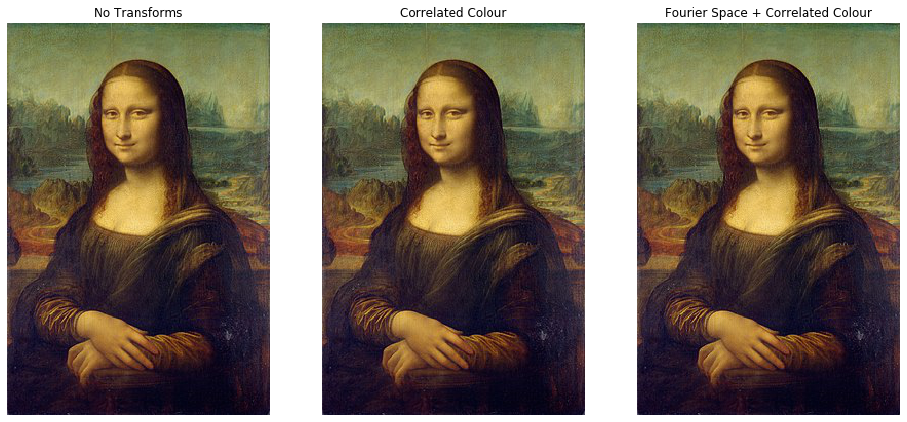

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from visual import TensorImage, FFTImage

image1 = TensorImage(torch.zeros(3, 763, 512), correlate=False).sigmoid().load_file('mona_lisa.jpg')
image2 = TensorImage(torch.zeros(3, 763, 512), correlate=True).sigmoid().load_file('mona_lisa.jpg')
image3 = FFTImage((3, 763, 512), correlate=True, decay_power=1.5, sd=0.1).sigmoid().load_file('mona_lisa.jpg')
image3.load_tensor(image3.get_valid_image())

plt.figure(figsize=(16,8))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('No Transforms')
image1.to_pyplot()

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Correlated Colour')
image2.to_pyplot()

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Fourier Space + Correlated Colour')
image3.to_pyplot()

Those all look quite similar so that's a good start!

## A Simple Dream

Now let's perform deep dreams with each one and compare the results. In practice we've found that the FFTImage variant needs fewer iterations to get the best results.

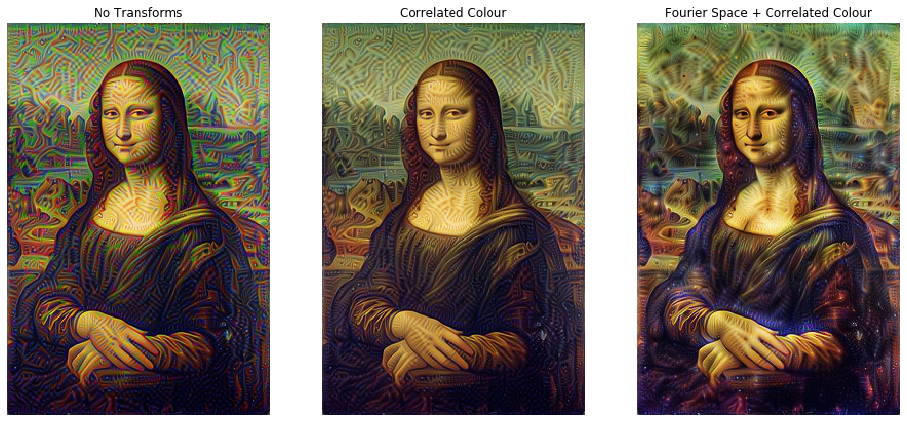

In [5]:
from matplotlib import pyplot as plt
from visual import Ascent, DeepDream, L2

image1 = TensorImage(torch.zeros(3, 763, 512), correlate=False, transform=transform).sigmoid().load_file('mona_lisa.jpg')
image2 = TensorImage(torch.zeros(3, 763, 512), correlate=True, transform=transform).sigmoid().load_file('mona_lisa.jpg')
image3 = FFTImage((3, 763, 512), correlate=True, transform=transform).sigmoid().load_file('mona_lisa.jpg')

criterion = DeepDream('model_features_10')

ascent1 = Ascent(image1, criterion, steps=16).to_pyplot()
ascent2 = Ascent(image2, criterion, steps=16).to_pyplot()
ascent3 = Ascent(image3, criterion, steps=12).to_pyplot()

plt.figure(figsize=(16,8))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('No Transforms')
ascent1.run(model, device='cuda', verbose=0)


plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Correlated Colour')
ascent2.run(model, device='cuda', verbose=0)

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Fourier Space + Correlated Colour')
ascent3.run(model, device='cuda', verbose=0)

## Pyramid Ascent

The full deep dream approach includes progressively upsampling the image, performing gradient ascent at each scale. Thanks to the `load_tensor` method, visual can take this to a new level by performing this pyramid ascent in fourier space. This functionality is bundled into the `PyramidAscent` class which works just like the `Ascent` class we've seen before. Let's have a look at what happens when we use this in conjuntion with an `FFTImage` on a larger picture of the mona lisa:

(-0.5, 511.5, 762.5, -0.5)

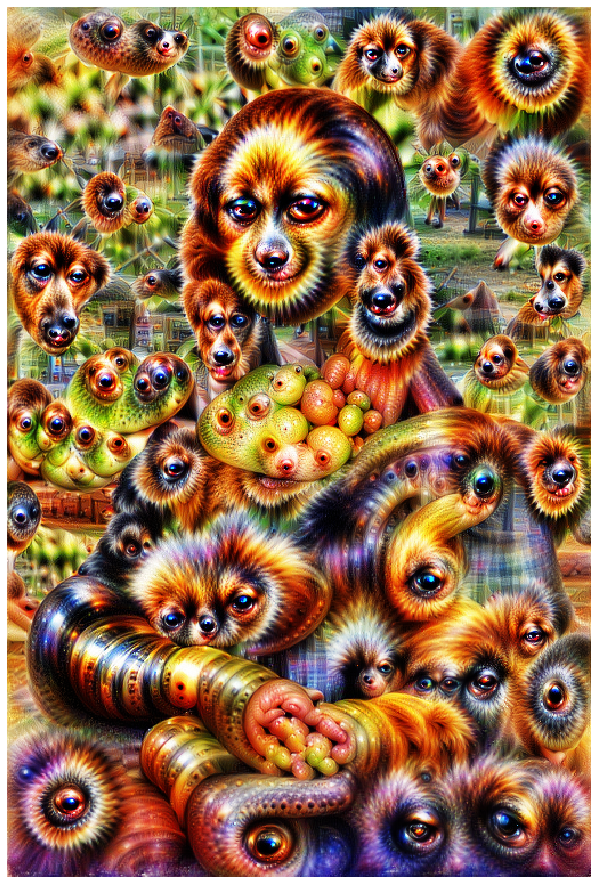

In [7]:
!wget -q -O mona_lisa_large.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/512px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg

%matplotlib inline
import matplotlib.pyplot as plt
import torch
from visual import Channel, TensorImage, DeepDream, FFTImage, PyramidAscent

image = FFTImage((3, 512, 512), correlate=True,
                 transform=transform, decay_power=1.2, sd=0.05).sigmoid().load_file('mona_lisa_large.jpg')

criterion = DeepDream('model_features_23')

plt.figure(figsize=(16,16))

PyramidAscent(image, criterion, scales=4, scale_factor=1.3, steps=18).run(model, device='cuda', verbose=0)
image.to_file('dream.png').to_pyplot()

plt.axis('off')

Well, that's unsettling. There's plenty more that can be done with deep dream and FFT images. We encourage you to have a play around and see what you can come up with. Otherwise take a look at the other notebooks that can be found in [our README](https://github.com/pytorchbearer/visual).